## <center>RNN forecasting a Sine Wave</center>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
x = np.linspace(0,50,501)
y = np.sin(x)

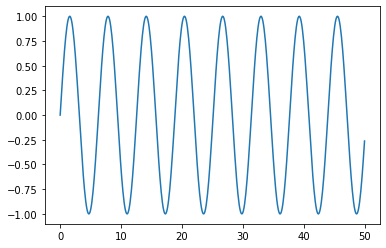

In [3]:
plt.plot(x,y)

Let's turn this into a DataFrame

In [4]:
df = pd.DataFrame(data=y,index=x,columns=['Sine'])
df.head()

,Sine
0.0,0.000000
0.1,0.099833
0.2,0.198669
0.3,0.295520
0.4,0.389418


### Train Test Split

Note! This is very different from our usual test/train split methodology!

In [5]:
len(df)

501

In [6]:
test_percent = 0.1
test_size = np.round(len(df)*test_percent)
test_size

50.0

In [7]:
test_ind = int(len(df)- test_size)

train = df.iloc[:test_ind]
test = df.iloc[test_ind:]

#### Scale Data

In [8]:
from sklearn.preprocessing import MinMaxScaler

In [9]:
scaler = MinMaxScaler()

scaled_train = scaler.fit_transform(train)
scaled_test = scaler.transform(test)

In this case, due to the fact that the output of the RNN is inputed again inside the Neural Network, it's important to scale it. 

### Time Series Generator

This class takes in a sequence of data-points gathered at
equal intervals, along with time series parameters such as
stride, length of history, etc., to produce batches for
training/validation.

In [10]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

#### Arguments
    data: Indexable generator (such as list or Numpy array)
        containing consecutive data points (timesteps).
        The data should be at 2D, and axis 0 is expected
        to be the time dimension.
    targets: Targets corresponding to timesteps in `data`.
        It should have same length as `data`.
    length: Length of the output sequences (in number of timesteps).
    sampling_rate: Period between successive individual timesteps
        within sequences. For rate `r`, timesteps
        `data[i]`, `data[i-r]`, ... `data[i - length]`
        are used for create a sample sequence.
    stride: Period between successive output sequences.
        For stride `s`, consecutive output samples would
        be centered around `data[i]`, `data[i+s]`, `data[i+2*s]`, etc.
    start_index: Data points earlier than `start_index` will not be used
        in the output sequences. This is useful to reserve part of the
        data for test or validation.
    end_index: Data points later than `end_index` will not be used
        in the output sequences. This is useful to reserve part of the
        data for test or validation.
    shuffle: Whether to shuffle output samples,
        or instead draw them in chronological order.
    reverse: Boolean: if `true`, timesteps in each output sample will be
        in reverse chronological order.
    batch_size: Number of timeseries samples in each batch
        (except maybe the last one).

In [11]:
# define generator
length = 2 # Length of the output sequences (in number of timesteps)
batch_size = 1 #Number of timeseries samples in each batch

generator = TimeseriesGenerator(data=scaled_train, # Where is the X
                                targets=scaled_train, # Where is the y
                                length=length, 
                                batch_size=batch_size)

In [12]:
print(len(scaled_train))
print(len(generator))  # n_input = 2

# In this case is 451 - 2 (length)

451
449


In [13]:
# What does the first batch look like?
X,y = generator[0]

In [14]:
scaled_train[:length + 1]

array([[0.49999912],
       [0.54991622],
       [0.59933458]])

In [15]:
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y.flatten()}')

Given the Array: 
[0.49999912 0.54991622]
Predict this y: 
 [0.59933458]


In [16]:
# Let's redefine to get 10 steps back and then predict the next step out
length = 10 # Length of the output sequences (in number of timesteps)
generator = TimeseriesGenerator(scaled_train, scaled_train, length=length, batch_size=1)

X,y = generator[0]

In [17]:
scaled_train[:length + 1]

array([[0.49999912],
       [0.54991622],
       [0.59933458],
       [0.64776041],
       [0.69470985],
       [0.73971381],
       [0.78232262],
       [0.82211054],
       [0.85868004],
       [0.89166571],
       [0.92073798]])

In [18]:
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y.flatten()}')

Given the Array: 
[0.49999912 0.54991622 0.59933458 0.64776041 0.69470985 0.73971381
 0.78232262 0.82211054 0.85868004 0.89166571]
Predict this y: 
 [0.92073798]


In [19]:
length = 50 # Length of the output sequences (in number of timesteps)
generator = TimeseriesGenerator(scaled_train, scaled_train, length=length, batch_size=1)

X,y = generator[0]

In [20]:
scaled_train[:length + 1]

array([[4.99999116e-01],
       [5.49916225e-01],
       [5.99334579e-01],
       [6.47760405e-01],
       [6.94709850e-01],
       [7.39713809e-01],
       [7.82322618e-01],
       [8.22110545e-01],
       [8.58680040e-01],
       [8.91665714e-01],
       [9.20737985e-01],
       [9.45606372e-01],
       [9.66022399e-01],
       [9.81782075e-01],
       [9.92727935e-01],
       [9.98750612e-01],
       [9.99789928e-01],
       [9.95835500e-01],
       [9.86926839e-01],
       [9.73152957e-01],
       [9.54651478e-01],
       [9.31607263e-01],
       [9.04250562e-01],
       [8.72854714e-01],
       [8.37733417e-01],
       [7.99237589e-01],
       [7.57751870e-01],
       [7.13690771e-01],
       [6.67494535e-01],
       [6.19624741e-01],
       [5.70559686e-01],
       [5.20789614e-01],
       [4.70811810e-01],
       [4.21125636e-01],
       [3.72227539e-01],
       [3.24606094e-01],
       [2.78737119e-01],
       [2.35078919e-01],
       [1.94067715e-01],
       [1.56113277e-01],


In [21]:
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y.flatten()}')

Given the Array: 
[4.99999116e-01 5.49916225e-01 5.99334579e-01 6.47760405e-01
 6.94709850e-01 7.39713809e-01 7.82322618e-01 8.22110545e-01
 8.58680040e-01 8.91665714e-01 9.20737985e-01 9.45606372e-01
 9.66022399e-01 9.81782075e-01 9.92727935e-01 9.98750612e-01
 9.99789928e-01 9.95835500e-01 9.86926839e-01 9.73152957e-01
 9.54651478e-01 9.31607263e-01 9.04250562e-01 8.72854714e-01
 8.37733417e-01 7.99237589e-01 7.57751870e-01 7.13690771e-01
 6.67494535e-01 6.19624741e-01 5.70559686e-01 5.20789614e-01
 4.70811810e-01 4.21125636e-01 3.72227539e-01 3.24606094e-01
 2.78737119e-01 2.35078919e-01 1.94067715e-01 1.56113277e-01
 1.21594831e-01 9.08572769e-02 6.42077324e-02 4.19124713e-02
 2.41942605e-02 1.12301346e-02 3.14962674e-03 3.34747619e-05
 1.91281421e-03 8.76886734e-03]
Predict this y: 
 [0.02053313]


### Create the Model

In [22]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM,SimpleRNN

In [23]:
# We're only using one feature in our time series
n_features = 1 # We just have x to predict y

In [24]:
# define model
model = Sequential()

# Simple RNN layer
model.add(SimpleRNN(50, input_shape=(length, n_features)))

# Final Prediction
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')

In [25]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 50)                2600      
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 2,651
Trainable params: 2,651
Non-trainable params: 0
_________________________________________________________________


In [26]:
# fit model
model.fit_generator(generator,epochs=5)

Epoch 1/5


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_17384\2200378995.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(generator,epochs=5)


401/401 [==============================] - 2s 4ms/step - loss: 0.0048
Epoch 2/5
401/401 [==============================] - 2s 4ms/step - loss: 1.9226e-04
Epoch 3/5
401/401 [==============================] - 2s 4ms/step - loss: 5.4467e-05
Epoch 4/5
401/401 [==============================] - 2s 4ms/step - loss: 5.6291e-04
Epoch 5/5
401/401 [==============================] - 2s 4ms/step - loss: 4.0216e-05


<AxesSubplot:>

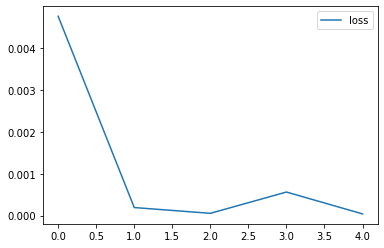

In [27]:
losses = pd.DataFrame(model.history.history)
losses.plot()

#### Evaluate on Test Data

The evaluate the test data, the last point of the train data must be taken to evaluate/forcast the first point of the test data.

----
Step by step, first iteration

In [28]:
first_eval_batch = scaled_train[-length:]
first_eval_batch = first_eval_batch.reshape((1, length, n_features)) # Must be reshaped, otherwise won't work

In [29]:
model.predict(first_eval_batch)[0].item()

1/1 [==============================] - 0s 181ms/step


0.9451969265937805

In [30]:
scaled_test[0]

array([0.94955134])

----

In [31]:
test_predictions = []

first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(len(test)):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    # store prediction
    test_predictions.append(current_pred) 
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

1/1 [==============================] - 0s 13ms/step


In [32]:
test_predictions

[array([0.9451969], dtype=float32),
 array([0.96370035], dtype=float32),
 array([0.9782633], dtype=float32),
 array([0.9862108], dtype=float32),
 array([0.989633], dtype=float32),
 array([0.9880664], dtype=float32),
 array([0.9822048], dtype=float32),
 array([0.9716829], dtype=float32),
 array([0.95635134], dtype=float32),
 array([0.93753356], dtype=float32),
 array([0.91378224], dtype=float32),
 array([0.8865012], dtype=float32),
 array([0.85575616], dtype=float32),
 array([0.82147664], dtype=float32),
 array([0.7840288], dtype=float32),
 array([0.7440619], dtype=float32),
 array([0.70214486], dtype=float32),
 array([0.65836424], dtype=float32),
 array([0.61227375], dtype=float32),
 array([0.5651586], dtype=float32),
 array([0.5180724], dtype=float32),
 array([0.47035998], dtype=float32),
 array([0.4214818], dtype=float32),
 array([0.3734508], dtype=float32),
 array([0.32677123], dtype=float32),
 array([0.28063473], dtype=float32),
 array([0.23578075], dtype=float32),
 array([0.193836

In [33]:
scaled_test

array([[9.49551344e-01],
       [9.69156618e-01],
       [9.84074225e-01],
       [9.94155114e-01],
       [9.99298559e-01],
       [9.99453170e-01],
       [9.94617400e-01],
       [9.84839568e-01],
       [9.70217371e-01],
       [9.50896908e-01],
       [9.27071224e-01],
       [8.98978376e-01],
       [8.66899060e-01],
       [8.31153800e-01],
       [7.92099752e-01],
       [7.50127132e-01],
       [7.05655314e-01],
       [6.59128649e-01],
       [6.11012013e-01],
       [5.61786173e-01],
       [5.11942978e-01],
       [4.61980443e-01],
       [4.12397778e-01],
       [3.63690397e-01],
       [3.16344967e-01],
       [2.70834550e-01],
       [2.27613868e-01],
       [1.87114770e-01],
       [1.49741909e-01],
       [1.15868702e-01],
       [8.58335998e-02],
       [5.99367021e-02],
       [3.84367625e-02],
       [2.15486014e-02],
       [9.44095974e-03],
       [2.23481297e-03],
       [2.16257798e-06],
       [2.76531647e-03],
       [1.04966661e-02],
       [2.31189624e-02],


#### Inverse Transformations and Compare

In [34]:
true_predictions = scaler.inverse_transform(test_predictions)

In [35]:
# IGNORE WARNINGS
test['Predictions'] = true_predictions
test.head()

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_17384\4258212321.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions'] = true_predictions


,Sine,Predictions
45.1,0.899097,0.890388
45.2,0.938307,0.927395
45.3,0.968142,0.956521
45.4,0.988304,0.972416
45.5,0.998591,0.979260


<AxesSubplot:>

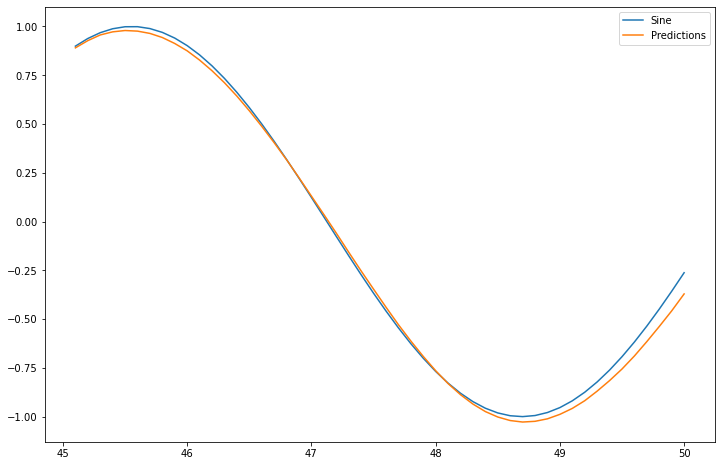

In [36]:
test.plot(figsize=(12,8))

#### Adding in Early Stopping and Validation Generator

In [37]:
from tensorflow.keras.callbacks import EarlyStopping

In [38]:
early_stop = EarlyStopping(monitor='val_loss',patience=2)

In [39]:
# To avoid the following error:

# `start_index+length=50 > end_index=49` is disallowed, as no part of the sequence would be left to be used as current step.
# The validation generator has to be bigger than the length of batches, so the length is set 1 value smaller




length = 49
generator = TimeseriesGenerator(scaled_train,scaled_train,
                               length=length,batch_size=1)


validation_generator = TimeseriesGenerator(scaled_test,scaled_test,
                                          length=length, batch_size=1)



### LSTMS

In [40]:
# define model
model = Sequential()

# Simple RNN layer
model.add(LSTM(50,input_shape=(length, n_features)))

# Final Prediction
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')

In [41]:
model.fit_generator(generator,epochs=20,
                   validation_data=validation_generator,
                   callbacks=[early_stop])

Epoch 1/20


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_17384\1950115197.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(generator,epochs=20,


402/402 [==============================] - 6s 11ms/step - loss: 0.0174 - val_loss: 2.1653e-04
Epoch 2/20
402/402 [==============================] - 4s 10ms/step - loss: 1.2511e-04 - val_loss: 3.3287e-05
Epoch 3/20
402/402 [==============================] - 4s 10ms/step - loss: 1.8471e-04 - val_loss: 7.4629e-05
Epoch 4/20
402/402 [==============================] - 4s 10ms/step - loss: 3.1066e-04 - val_loss: 7.4586e-05


In [42]:
test_predictions = []

first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(len(test)):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    test_predictions.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

1/1 [==============================] - 0s 17ms/step


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_17384\1584625205.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['LSTM Predictions'] = true_predictions


<AxesSubplot:>

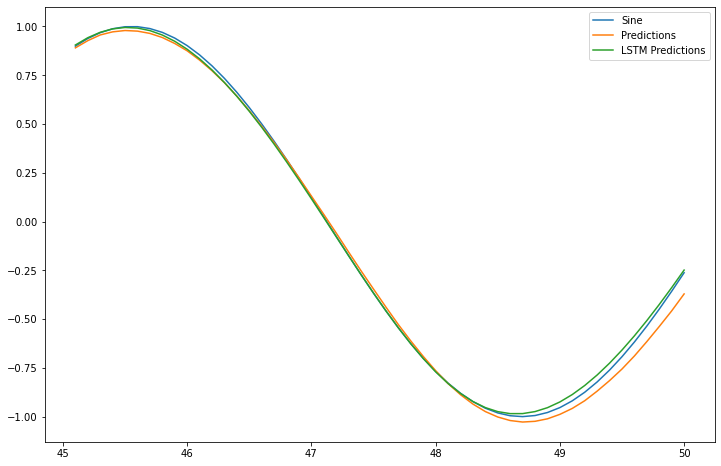

In [43]:
# IGNORE WARNINGS
true_predictions = scaler.inverse_transform(test_predictions)
test['LSTM Predictions'] = true_predictions
test.plot(figsize=(12,8))

### Forecasting

Forecast into unknown range. We should first utilize all our data, since we are now forecasting!

In [44]:
full_scaler = MinMaxScaler()
scaled_full_data = full_scaler.fit_transform(df)

In [45]:
length = 100 # Length of the output sequences (in number of timesteps)
generator = TimeseriesGenerator(scaled_full_data, scaled_full_data, length=length, batch_size=1)

In [46]:
model = Sequential()
model.add(LSTM(length, input_shape=(length, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.fit_generator(generator,epochs=6)

Epoch 1/6


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_17384\1885992695.py:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(generator,epochs=6)


401/401 [==============================] - 8s 15ms/step - loss: 0.0065
Epoch 2/6
401/401 [==============================] - 6s 15ms/step - loss: 4.0579e-04
Epoch 3/6
401/401 [==============================] - 6s 15ms/step - loss: 7.8144e-05
Epoch 4/6
401/401 [==============================] - 6s 15ms/step - loss: 7.0524e-05
Epoch 5/6
401/401 [==============================] - 6s 16ms/step - loss: 7.8928e-04
Epoch 6/6
401/401 [==============================] - 6s 15ms/step - loss: 2.9001e-05


In [47]:
forecast = []

first_eval_batch = scaled_full_data[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(length):
    
    current_pred = model.predict(current_batch)[0]
    forecast.append(current_pred) 
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

1/1 [==============================] - 0s 19ms/step


In [48]:
forecast = scaler.inverse_transform(forecast)
forecast_index = np.arange(50.1,50.1+length*0.1,step=0.1)

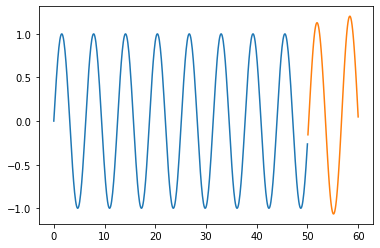

In [49]:
plt.plot(df.index,df['Sine'])
plt.plot(forecast_index,forecast)